In [1]:
import matplotlib.pyplot as plt

from langchain_ollama.llms import OllamaLLM
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain

import sys
import os

In [2]:
#FUNCIONES PERSONALIZADAS PARA LOS MODELOS
sys.path.append(os.path.abspath("../funciones"))

#IMPORAR FUNCIONES AUXILIARES PERSONALIZADAS DESDE EL MÓDULO
from funcionesEntrenamientoLLM import (
    cargar_datos_entrenamiento,
    imprimir_forma,
    obtener_predicciones,
    reporte_clasificacion,
    crear_matriz_confusion,
    calcular_roc_auc,
    metricas_tpr_fpr,
)

In [3]:
#CARGA Y PREPARACIÓN DE DATOS DE ENTRENAMIENTO
X, y_reales = cargar_datos_entrenamiento()

shape, head = imprimir_forma(X)
print("Shape: ", shape)
head

Shape:  (1500,)


0    Cheesecake saludable sin azúcar y sin lactosa ...
1                 ser como ellas ♡♡\n  #HastaLosHuesos
2    Comida Real o , la clave para estar más sana, ...
3    Entre el cambio de hora y la bajada de las #te...
4       Hace mucho tiempo no sentía mi cuerpo tan frío
Name: tweet_text, dtype: object

In [4]:
# Inicializar modelo LLaMA3 vía Ollama
llm = OllamaLLM(model="llama3")

In [5]:
# Crear el prompt con few-shot
prompt = PromptTemplate.from_template("""
Eres un asistente experto en salud mental. Tu tarea es analizar tweets e indicar si muestran señales de un posible trastorno alimenticio (como anorexia, bulimia, o similares).

Responde únicamente con "Sí" si el tweet indica un posible trastorno alimenticio, y con "No" si no lo indica.

Ejemplos:
Tweet: "no comí en todo el día y me siento bien" → Sí
Tweet: "me encanta comer con mis amigos los fines de semana" → No
Tweet: "me siento gorda incluso si no como nada" → Sí
Tweet: "hoy hice ejercicio y luego almorcé con mi familia" → No
Tweet: "ser como ellas ♡♡
  #hastaLoshuesos" → Sí
Tweet: "hoy #domingo os esperamos desde las 10:00 de la mañana para empezar el día con un buen desayuno.

también podéis reservar mesa para comer o cenar y disfrutar de nuestra carta o del menú fin de semana.
 980 56 99 34

#felizdomingo #restaurantealabros #zamora  #yum" → No

Ahora, clasifica el siguiente tweet, recuerda responder únicamente con dos letras en cada caso 'Sí' o 'No', sin explicaciones, como se muestra en los ejemplos. También recuerda que lo que recibes como input es únicamente el tweet y nada más que el tweet al que tienes que clasificar:
Tweet: "{tweet}" → 
""")

In [6]:
# Crear el pipeline
chain = LLMChain(prompt=prompt, llm=llm)

C:\Users\saaso\AppData\Local\Temp\ipykernel_7340\3755763389.py:2: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(prompt=prompt, llm=llm)


In [7]:
# Obtener predicciones
predicciones = obtener_predicciones(chain, X)

Clasificando tweets con LLaMA3: 100%|██████████| 1500/1500 [03:58<00:00,  6.29it/s]


In [8]:
y_preds, reporte = reporte_clasificacion(predicciones, y_reales)

print("Classification Report:")
print(reporte)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.52      0.68       696
           1       0.70      0.98      0.82       804

    accuracy                           0.77      1500
   macro avg       0.83      0.75      0.75      1500
weighted avg       0.82      0.77      0.75      1500



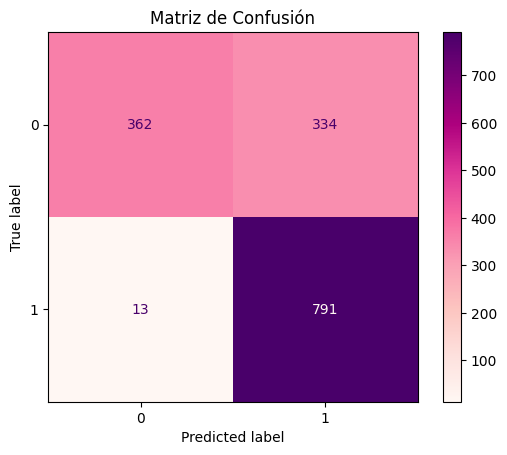

In [9]:
cm, disp = crear_matriz_confusion(y_reales, y_preds)

disp.plot(cmap='RdPu')
plt.title("Matriz de Confusión")
plt.show()

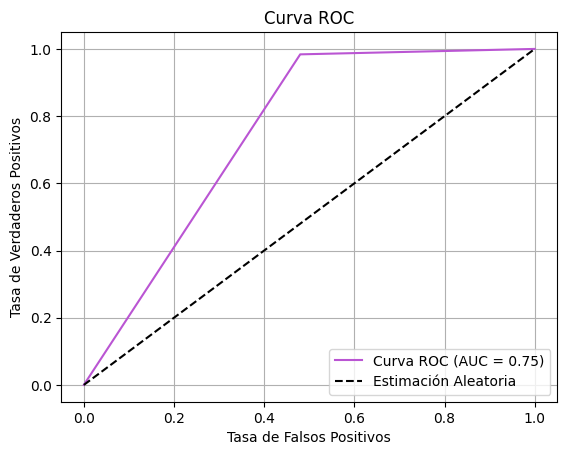

In [10]:
#CURVA ROC
fpr, tpr, thresholds, auc_score = calcular_roc_auc(y_reales, y_preds)

plt.figure()
plt.plot(fpr, tpr, color='mediumorchid', label=f"Curva ROC (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [11]:
#MÉTRICAS TPR/FPR
TPR, FPR = metricas_tpr_fpr(cm)

# Mostrar métricas
print(f"AUC: {(auc_score * 100):.4f}")
print(f"TPR (Tasa de Positivos Verdaderos): {(TPR * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR * 100):.4f}")

AUC: 75.1973
TPR (Tasa de Positivos Verdaderos): 98.3831
FPR (Tasa de Falsos Positivos): 47.9885
